In [1]:
import bulbea as bb
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas 
import pandas_datareader.data as web
import collections
import numbers
from bulbea.learn.models import RNN
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
class ShareObj():

    def to_get_data(self,source, tinker):
        end=dt.datetime.now()
        start = dt.datetime(end.year-1,end.month,end.day)
        df = web.DataReader(tinker,source,start,end)
        df.to_csv(str(tinker+".csv"))
        #df.head()
        #df[['High','Low','Open','Close']].plot()
        return df

    def __init__(self,source,code):
        self.code=code
        self.data=self.to_get_data(source,code)
    


In [3]:
def split(share,
          attrs     = 'Close',
          window    = 0.01,
          train     = 0.80,
          shift     = 1,
          normalize = False):
    '''
    :param attrs: `str` or `list` of attribute names of a share, defaults to *Close* attribute
    :type attrs: :obj: `str`, :obj:`list`
    '''
    #_check_type(share, type_ = bb.Share, raise_err = True, expected_type_name = 'bulbea.Share')
    _check_iterable(attrs, raise_err = True)
    _check_int(shift, raise_err = True)
    _check_real(window, raise_err = True)
    _check_real(train, raise_err = True)

    _validate_in_range(window, 0, 1, raise_err = True)
    _validate_in_range(train, 0, 1, raise_err = True)

    data   = share.data[attrs]
    #print(data)

    length = len(share.data)
    #print(length)

    window = int(np.rint(length * window))
    offset = shift - 1
    #print(window,offset)

    splits = np.array([data[i if i is 0 else i + offset: i + window] for i in range(length - window)])

    #print(splits.shape)

    if normalize:
        splits = np.array([_get_cummulative_return(split) for split in splits])

    size   = len(splits)
    split  = int(np.rint(train * size))

    train  = splits[:split,:]
    test   = splits[split:,:]

    Xtrain, Xtest = train[:,:-1], test[:,:-1]
    ytrain, ytest = train[:, -1], test[:, -1]

    return (Xtrain, Xtest, ytrain, ytest)
    

In [4]:
def _check_iterable(o, raise_err = False):
    return _check_type(o, collections.Iterable, raise_err = raise_err, expected_type_name = '(str, list, tuple)')
def _check_int(o, raise_err = False):
    return _check_type(o, numbers.Integral, raise_err = raise_err, expected_type_name = 'int')
def _check_real(o, raise_err = False):
    return _check_type(o, numbers.Real, raise_err = raise_err, expected_type_name = '(int, float)')
def _validate_in_range(value, low, high, raise_err = False):
    if not low <= value <= high:
        if raise_err:
            raise ValueError('{value} out of bounds, must be in range [{low}, {high}].'.format(
                value = value,
                low   = low,
                high  = high
            ))
        else:
            return False
    else:
        return True
def _check_type(o, type_, raise_err = False, expected_type_name = None):
    if not isinstance(o, type_):
        if raise_err:
            _raise_type_error(
                expected_type_name = expected_type_name,
                recieved_type_name = _get_type_name(o)
            )
        else:
            return False
    else:
        return True

In [5]:
def _get_cummulative_return(data):
    cumret  = (data / data[0]) - 1
    return cumret

In [6]:
def get_data(date,window,sentiment,df,normalize = True):
    #print(df)
    all_dates = df['Date']
    try:             
        value = df['Close'].where(df['Date'] == date)
        c = np.where(df['Close'] == value)
        search_index = int(c[0])
        test_set = list(df['Close'][search_index - window:search_index])
        test_set = np.array(test_set)
        print(test_set)
        thresh_val = test_set[0]
        if normalize == True:
            test_set = np.array([_get_cummulative_return(test_set)])
            
        return test_set, thresh_val
    except:
        print("date is not there!!")
        date = pandas.to_datetime(date)
        date = date - np.timedelta64(1,'D')
        #print(date)
        new_date = pandas.to_datetime(date).date()
        #print(str(new_date))
        test_set, thresh_val = get_data(str(new_date),window,sentiment,df,normalize = True)
        return test_set, thresh_val
        
    
       

    

    

In [93]:

def get_prediction_by_date(input_date, stock_name):
    
    share = ShareObj("yahoo",stock_name)
    print("DATA OF GIVEN STOCK PRICE FOR 1 YEAR")
    print(share.data)
    len(share.data)
    
    Xtrain, Xtest, ytrain, ytest = split(share, 'Close',window= 0.02, normalize=True)
    print(Xtrain.shape)

    Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
    Xtest  = np.reshape( Xtest, ( Xtest.shape[0],  Xtest.shape[1], 1))



    rnn = RNN([1, 100, 100, 1]) # number of neurons in each layer
    rnn.fit(Xtrain, ytrain, batch_size = 64, nb_epoch= 10, validation_split= 0.01)
    
    print("Analysing closing price for before few days of given date..")
    dates = share.data.index
    df = share.data.reset_index()
    test_data, thresh_val= get_data(input_date,Xtrain.shape[1],"positive",df, True)
    print(test_data, thresh_val)
    print(test_data.shape)
    
    p = rnn.predict(Xtest)
    mean_squared_error(ytest, p)
    

    test_data  = np.reshape( test_data, ( test_data.shape[0],  test_data.shape[1], 1))
    pred = rnn.predict(test_data)
    print(pred)
    print("predicted value for given date:")
    print((pred+1)*thresh_val)
    predicted_val = (pred+1)*thresh_val
    return predicted_val[0][0]






In [95]:
input_date = "2019-09-13"
stock_name = "AMZN"
# source_csv = {stock_name: str(stock_name+'.csv')}
predicted_val = get_prediction_by_date(input_date, stock_name)
print(predicted_val)

DATA OF GIVEN STOCK PRICE FOR 1 YEAR
                   High          Low         Open        Close    Volume  \
Date                                                                       
2018-09-14  1993.650024  1959.219971  1992.930054  1970.189941   3642000   
2018-09-17  1956.819946  1887.410034  1954.729980  1908.030029   7050200   
2018-09-18  1958.199951  1915.439941  1918.650024  1941.050049   4268700   
2018-09-19  1940.829956  1904.900024  1940.500000  1926.420044   4056800   
2018-09-20  1955.000000  1932.250000  1938.579956  1944.300049   3154900   
2018-09-21  1957.310059  1910.500000  1954.219971  1915.010010   6855900   
2018-09-24  1936.880005  1865.000000  1903.790039  1934.359985   4213700   
2018-09-25  1975.910034  1938.849976  1942.900024  1974.550049   4538400   
2018-09-26  1995.250000  1961.520020  1968.500000  1974.849976   4313500   
2018-09-27  2016.160034  1988.579956  1993.239990  2012.979980   4329400   
2018-09-28  2026.520020  1996.459961  2004.410034  

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 16s 84ms/step - loss: 0.0024 - val_loss: 4.2104e-04
Epoch 2/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 3/10
195/195 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 4/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 7.9671e-05
Epoch 5/10
195/195 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 3.5448e-04
Epoch 6/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 4.3951e-05
Epoch 7/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 0.0028
Epoch 8/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 4.3631e-04
Epoch 9/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 7.5282e-04
Epoch 10/10
195/195 [=========

In [86]:
print(Xtest, ytest)

[ 0.02602411  0.01567483  0.02791176  0.04043839  0.02993443  0.03005658
  0.01644115 -0.0037226  -0.00451754 -0.01645946 -0.02794174 -0.01207524
  0.0012349   0.01158301  0.00473394 -0.02144405 -0.04113334 -0.05111931
 -0.05422983 -0.04515072 -0.04664695 -0.0702649  -0.04229211 -0.03337426
  0.00529279  0.02404919 -0.00162762  0.01725211 -0.03815289 -0.01740446
  0.00428585 -0.00450572  0.02179292  0.02669867  0.00674456 -0.03661652
 -0.01804728 -0.03384082 -0.02239205  0.02102172  0.00419479  0.01589825
  0.02061499  0.03040749  0.03221319  0.02319202  0.01106844 -0.00963209
  0.00547586] [[[ 0.        ]
  [ 0.01508211]
  [ 0.02148258]
  [ 0.02395927]]

 [[ 0.        ]
  [ 0.00630537]
  [ 0.00874526]
  [ 0.01077942]]

 [[ 0.        ]
  [ 0.00242461]
  [ 0.00444602]
  [ 0.00931076]]

 [[ 0.        ]
  [ 0.00201652]
  [ 0.00686949]
  [ 0.0254255 ]]

 [[ 0.        ]
  [ 0.00484321]
  [ 0.02336187]
  [ 0.03834454]]

 [[ 0.        ]
  [ 0.01842941]
  [ 0.03333987]
  [ 0.02497029]]

 [[ 0.

In [65]:
dates = ["2019-09-14","2019-09-13","2019-09-12","2019-09-11","2019-09-10","2019-09-09","2019-09-06","2019-09-05","2019-09-04","2019-09-03"]

predicted_all_vals = []
for single_d in dates:
    stock_name = "AMZN"
    # source_csv = {stock_name: str(stock_name+'.csv')}
    predicted_val = get_prediction_by_date(single_d, stock_name)
    predicted_all_vals.append(predicted_val)
    

DATA OF GIVEN STOCK PRICE FOR 1 YEAR
                   High          Low         Open        Close    Volume  \
Date                                                                       
2018-09-14  1993.650024  1959.219971  1992.930054  1970.189941   3642000   
2018-09-17  1956.819946  1887.410034  1954.729980  1908.030029   7050200   
2018-09-18  1958.199951  1915.439941  1918.650024  1941.050049   4268700   
2018-09-19  1940.829956  1904.900024  1940.500000  1926.420044   4056800   
2018-09-20  1955.000000  1932.250000  1938.579956  1944.300049   3154900   
2018-09-21  1957.310059  1910.500000  1954.219971  1915.010010   6855900   
2018-09-24  1936.880005  1865.000000  1903.790039  1934.359985   4213700   
2018-09-25  1975.910034  1938.849976  1942.900024  1974.550049   4538400   
2018-09-26  1995.250000  1961.520020  1968.500000  1974.849976   4313500   
2018-09-27  2016.160034  1988.579956  1993.239990  2012.979980   4329400   
2018-09-28  2026.520020  1996.459961  2004.410034  

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 9s 44ms/step - loss: 0.0023 - val_loss: 5.3011e-05
Epoch 2/10
195/195 [==============================] - 0s 389us/step - loss: 0.0021 - val_loss: 9.7284e-05
Epoch 3/10
195/195 [==============================] - 0s 425us/step - loss: 0.0017 - val_loss: 6.5393e-04
Epoch 4/10
195/195 [==============================] - 0s 343us/step - loss: 0.0016 - val_loss: 4.8759e-04
Epoch 5/10
195/195 [==============================] - 0s 583us/step - loss: 0.0020 - val_loss: 2.4720e-04
Epoch 6/10
195/195 [==============================] - 0s 389us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/10
195/195 [==============================] - 0s 373us/step - loss: 0.0012 - val_loss: 4.8844e-04
Epoch 8/10
195/195 [==============================] - 0s 343us/step - loss: 0.0012 - val_loss: 4.6289e-04
Epoch 9/10
195/195 [==============================] - 0s 343us/step - loss: 0.0011 - val_loss: 5.5725e-04
Epoch 1

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 9s 44ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 2/10
195/195 [==============================] - 0s 455us/step - loss: 0.0020 - val_loss: 1.9250e-04
Epoch 3/10
195/195 [==============================] - 0s 384us/step - loss: 0.0017 - val_loss: 4.1211e-05
Epoch 4/10
195/195 [==============================] - 0s 384us/step - loss: 0.0016 - val_loss: 9.8482e-05
Epoch 5/10
195/195 [==============================] - 0s 368us/step - loss: 0.0015 - val_loss: 3.4698e-04
Epoch 6/10
195/195 [==============================] - 0s 378us/step - loss: 0.0016 - val_loss: 6.2149e-04
Epoch 7/10
195/195 [==============================] - 0s 378us/step - loss: 0.0015 - val_loss: 6.2415e-05
Epoch 8/10
195/195 [==============================] - 0s 348us/step - loss: 0.0012 - val_loss: 6.0720e-04
Epoch 9/10
195/195 [==============================] - 0s 384us/step - loss: 0.0012 - val_loss: 0.0020
Epoch 10/10

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 9s 47ms/step - loss: 0.0023 - val_loss: 3.4667e-05
Epoch 2/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 6.2879e-04
Epoch 3/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 2.5915e-05
Epoch 4/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 7.0018e-04
Epoch 6/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 2.7035e-04
Epoch 7/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 8.3887e-04
Epoch 8/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 1.1826e-04
Epoch 9/10
195/195 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 6.0856e-05
Epoch 10/10
195/195 [==

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 9s 49ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 2/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 5.8755e-04
Epoch 3/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0016 - val_loss: 2.4739e-05
Epoch 4/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 5/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 4.2543e-05
Epoch 6/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 7/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 7.8921e-04
Epoch 8/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 7.3325e-04
Epoch 9/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 2.9537e-05
Epoch 10/10
195/195 [==========

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 9s 47ms/step - loss: 0.0020 - val_loss: 8.8327e-05
Epoch 2/10
195/195 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 4.0440e-05
Epoch 3/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 4.6646e-04
Epoch 4/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 1.2977e-05
Epoch 5/10
195/195 [==============================] - 1s 4ms/step - loss: 0.0015 - val_loss: 1.1879e-04
Epoch 6/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 9.9500e-06
Epoch 7/10
195/195 [==============================] - 0s 1ms/step - loss: 0.0017 - val_loss: 2.6101e-05
Epoch 8/10
195/195 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 6.8003e-04
Epoch 9/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 6.8671e-04
Epoch 10/10
195/195

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 10s 53ms/step - loss: 0.0023 - val_loss: 7.7238e-04
Epoch 2/10
195/195 [==============================] - 0s 1ms/step - loss: 0.0019 - val_loss: 0.0028
Epoch 3/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 4/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0017 - val_loss: 3.2097e-04
Epoch 5/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 8.7779e-05
Epoch 6/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 8.6294e-04
Epoch 7/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 4.1286e-04
Epoch 8/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 3.0579e-04
Epoch 10/10
195/195 [=========

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 13s 66ms/step - loss: 0.0025 - val_loss: 7.2760e-04
Epoch 2/10
195/195 [==============================] - 0s 389us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/10
195/195 [==============================] - 0s 844us/step - loss: 0.0018 - val_loss: 0.0020
Epoch 4/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 5/10
195/195 [==============================] - 0s 450us/step - loss: 0.0015 - val_loss: 6.9379e-04
Epoch 6/10
195/195 [==============================] - 0s 363us/step - loss: 0.0014 - val_loss: 2.2715e-04
Epoch 7/10
195/195 [==============================] - 0s 532us/step - loss: 0.0018 - val_loss: 1.4314e-06
Epoch 8/10
195/195 [==============================] - 0s 327us/step - loss: 0.0014 - val_loss: 1.1936e-04
Epoch 9/10
195/195 [==============================] - 0s 368us/step - loss: 0.0014 - val_loss: 1.2416e-04
Epoch 10/10
195/

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 10s 52ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 2/10
195/195 [==============================] - 0s 409us/step - loss: 0.0024 - val_loss: 7.3007e-05
Epoch 3/10
195/195 [==============================] - 0s 588us/step - loss: 0.0018 - val_loss: 9.4734e-04
Epoch 4/10
195/195 [==============================] - 0s 496us/step - loss: 0.0016 - val_loss: 8.6343e-05
Epoch 5/10
195/195 [==============================] - 0s 481us/step - loss: 0.0015 - val_loss: 6.2046e-06
Epoch 6/10
195/195 [==============================] - 0s 414us/step - loss: 0.0016 - val_loss: 7.2951e-06
Epoch 7/10
195/195 [==============================] - 0s 430us/step - loss: 0.0015 - val_loss: 7.7878e-04
Epoch 8/10
195/195 [==============================] - 0s 481us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/10
195/195 [==============================] - 0s 399us/step - loss: 0.0015 - val_loss: 5.2693e-04
Epoch 10/1

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 13s 69ms/step - loss: 0.0022 - val_loss: 3.5174e-04
Epoch 2/10
195/195 [==============================] - 0s 783us/step - loss: 0.0018 - val_loss: 4.4820e-06
Epoch 3/10
195/195 [==============================] - 0s 363us/step - loss: 0.0019 - val_loss: 4.6227e-05
Epoch 4/10
195/195 [==============================] - 0s 363us/step - loss: 0.0018 - val_loss: 5.0101e-04
Epoch 5/10
195/195 [==============================] - 0s 379us/step - loss: 0.0017 - val_loss: 8.1560e-04
Epoch 6/10
195/195 [==============================] - 0s 787us/step - loss: 0.0015 - val_loss: 3.6479e-05
Epoch 7/10
195/195 [==============================] - 0s 599us/step - loss: 0.0014 - val_loss: 4.3390e-04
Epoch 8/10
195/195 [==============================] - 0s 369us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 9/10
195/195 [==============================] - 0s 639us/step - loss: 0.0015 - val_loss: 0.0025
Epoch 10/1

E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 12s 61ms/step - loss: 0.0022 - val_loss: 4.5673e-04
Epoch 2/10
195/195 [==============================] - 0s 419us/step - loss: 0.0018 - val_loss: 0.0023
Epoch 3/10
195/195 [==============================] - 0s 501us/step - loss: 0.0021 - val_loss: 4.7154e-07
Epoch 4/10
195/195 [==============================] - 0s 496us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/10
195/195 [==============================] - 0s 639us/step - loss: 0.0016 - val_loss: 1.6090e-04
Epoch 6/10
195/195 [==============================] - 0s 941us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/10
195/195 [==============================] - 0s 424us/step - loss: 0.0014 - val_loss: 0.0028
Epoch 8/10
195/195 [==============================] - 0s 691us/step - loss: 0.0016 - val_loss: 1.9086e-04
Epoch 9/10
195/195 [==============================] - 0s 385us/step - loss: 0.0016 - val_loss: 9.9516e-05
Epoch 10/10
195/19

In [68]:
print(predicted_all_vals)


[1801.103, 1759.2618, 1784.8727, 1806.3235, 1880.8617, 1867.7891, 1783.2621, 1907.4783, 1837.7953, 1814.8242]


In [69]:
# predicted_all_vals = predicted_all_vals.reverse()
# gt_vals = gt_vals.reverse()
predicted_all_vals = [ 1814.8242, 1837.7953, 1907.4783, 1783.2621, 1867.7891, 1880.8617, 1806.3235, 1784.8727, 1759.2618, 1801.103 ]
dates = ["2019-09-14","2019-09-13","2019-09-12","2019-09-11","2019-09-10","2019-09-09","2019-09-06","2019-09-05","2019-09-04","2019-09-03"]

gt_vals=  [  1839.339966, 1843.550049 , 1822.989990 , 1820.550049 , 1831.349976 , 1833.510010 , 1840.719971, 1800.619995, 1789.839966]
dates_gt = ["2019-09-13","2019-09-12","2019-09-11","2019-09-10","2019-09-09","2019-09-06","2019-09-05","2019-09-04","2019-09-03"]

print(predicted_all_vals)
print(gt_vals)
predicted_all_vals.reverse()
gt_vals.reverse()
dates.reverse()
dates_gt.reverse()



[1814.8242, 1837.7953, 1907.4783, 1783.2621, 1867.7891, 1880.8617, 1806.3235, 1784.8727, 1759.2618, 1801.103]
[1839.339966, 1843.550049, 1822.98999, 1820.550049, 1831.349976, 1833.51001, 1840.719971, 1800.619995, 1789.839966]


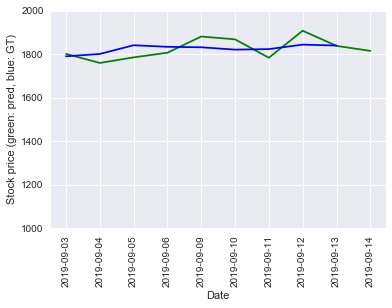

In [81]:
import matplotlib.pyplot as pplt
# pplt.set_ylim([1000, 2000])
pplt.plot(dates,predicted_all_vals , 'g')  #preditect green
pplt.plot(dates_gt, gt_vals, 'b')
pplt.xticks(rotation=90)
pplt.ylim((1000, 2000)) 
plt.xlabel('Date') 
plt.ylabel('Stock price (green: pred, blue: GT)') 
pplt.savefig('foo.png')
pplt.show()


(197, 4)


[231.78999329 235.53999329 247.1000061  245.86999512]
[[0.         0.01617844 0.06605122 0.06074465]] 231.7899932861328
(1, 4)


(49, 4) (197, 4)


Using TensorFlow backend.


E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return_sequences = True
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:29: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=100)`
  return_sequences = True



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  self.model.add(core.Dense(output_dim = sizes[-1]))
E:\hackathon_devengers\bulbea\bulbea\learn\models\ann.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  return self.model.fit(X, y, *args, **kwargs)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 195 samples, validate on 2 samples
Epoch 1/10
195/195 [==============================] - 2s 11ms/step - loss: 0.0045 - val_loss: 3.8190e-04
Epoch 2/10
195/195 [==============================] - 0s 430us/step - loss: 0.0038 - val_loss: 0.0017
Epoch 3/10
195/195 [==============================] - 0s 409us/step - loss: 0.0033 - val_loss: 0.0027
Epoch 4/10
195/195 [==============================] - 0s 425us/step - loss: 0.0031 - val_loss: 0.0013
Epoch 5/10
195/195 [==============================] - 0s 419us/step - loss: 0.0039 - val_loss: 0.0015
Epoch 6/10
195/195 [==============================] - 0s 404us/step - loss: 0.0025 - val_loss: 0.0012
Epoch 7/10
195/195 [==============================] - 0s 435us/step - loss: 0.0024 - val_loss: 7.3996e-04
Epoch 8/10
195/195 [==============================] - 0s 435us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/10
195/195 [==================

In [29]:
print(Xtrain.shape)

(197, 4, 1)


0.0022816622889131662

In [31]:
print(p.shape, ytest.shape)

(49, 1) (49,)


ValueError: x and y can be no greater than 2-D, but have shapes (49,) and (49, 4, 1)

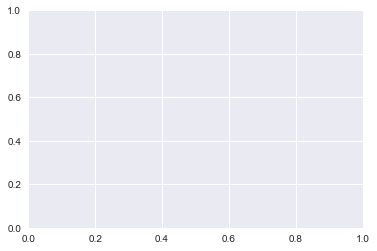

In [91]:
import matplotlib.pyplot as pplt
pplt.plot(ytest) #Blue
pplt.plot(p) #Green
pplt.show()

[[0.01897246]]


[[236.18764]]
